<h3> Customer Segmentation using RFM analysis and K-means clustering</h3>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import datetime
import squarify
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [4]:
#Importing the dataset
dataset = pd.read_csv(r"G:\machine_learning\ecommerce\data.csv", encoding="ISO-8859-1")
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
dataset.shape

(541909, 8)

In [6]:
dataset.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
dataset.isnull().sum().sort_values(ascending = False)

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

In [8]:
dataset.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<b> Observations </b>
   - Size of Dataset : 541909 x 8
   - Customer ID and Dscription contains missing values. Based on the dataset, It is not possible to impute values to these columns. So, the rows containing missing values for these fields should be removed.
   - 'InvoiceDate' has to be converted to datetime
   
    

- <b> Removing the missing values from the dataset </b>

In [9]:
dataset.dropna(axis = 0, subset = ["CustomerID"], inplace = True )
dataset.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

- <b> Removing duplicated rows </b>

In [10]:
dataset.duplicated().sum()

5225

In [11]:
dataset.drop_duplicates(inplace = True)
dataset.duplicated().sum()

0

- <b> Converting InvoiceDate type to datetime</b>

In [12]:
dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'])
dataset.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

 - <b> Calculating total price and number of orders cancelled </b>

In [13]:
dataset['TotalPrice'] = dataset['Quantity'] * dataset['UnitPrice']

In [14]:
dataset['OrderCancelled'] = dataset['InvoiceNo'].apply(lambda x: int('C' in x))

In [15]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,OrderCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0


In [16]:
dataset.groupby('OrderCancelled')['OrderCancelled'].count()

OrderCancelled
0    392732
1      8872
Name: OrderCancelled, dtype: int64

 - <b> Which Country spent more amount in purchasing? </b>

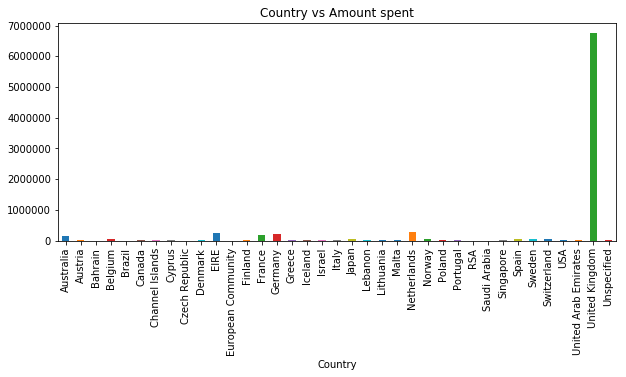

In [17]:
plt.figure(figsize=(10,4))
dataset.groupby('Country')['TotalPrice'].sum().plot.bar(title = "Country vs Amount spent")

- <b> RFM Analysis </b>

In [19]:
today = datetime.datetime.today()
data_rec_mon = dataset[dataset['OrderCancelled'] == 0].groupby('CustomerID').agg({'TotalPrice': lambda x: x.sum(),'InvoiceDate': lambda x: (today-x.max()).days})
data_rec_mon.head()

,TotalPrice,InvoiceDate
CustomerID,,
12346.0,77183.60,3480
12347.0,4310.00,3157
12348.0,1797.24,3230
12349.0,1757.55,3173
12350.0,334.40,3465


In [20]:
dataset_temp = dataset[dataset['OrderCancelled'] == 0].groupby(['CustomerID','InvoiceNo']).agg({'TotalPrice': lambda x: x.sum()})
dataset_temp.head()

TotalPrice
CustomerID InvoiceNo            
12346.0    541431       77183.60
12347.0    537626         711.79
           542237         475.39
           549222         636.25
           556201         382.52

In [21]:
dataset_frequency = dataset_temp.groupby('CustomerID').agg({'TotalPrice': lambda x: len(x)})
dataset_frequency.head()

,TotalPrice
CustomerID,
12346.0,1.0
12347.0,7.0
12348.0,4.0
12349.0,1.0
12350.0,1.0


In [22]:
dataset_rfm = pd.merge(data_rec_mon,dataset_frequency, on = 'CustomerID')
dataset_rfm.rename(columns= {'InvoiceDate': 'Recency',
                          'TotalPrice_y': 'Frequency',
                          'TotalPrice_x': 'Monetary'}, inplace= True)
dataset_rfm.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,77183.60,3480,1.0
12347.0,4310.00,3157,7.0
12348.0,1797.24,3230,4.0
12349.0,1757.55,3173,1.0
12350.0,334.40,3465,1.0


In [23]:
def frequency_score(x,p,d):
    if x <= d[p][0.20]:
        return 0
    elif x <= d[p][0.40]:
        return 1
    elif x <= d[p][0.60]: 
        return 2
    elif x <= d[p][0.80]:
        return 3
    else:
        return 4
    
quantiles = dataset_rfm.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()
dataset_rfm['Frequency_Tile'] = dataset_rfm['Frequency'].apply(frequency_score, args=('Frequency',quantiles,))
dataset_rfm['Recency_tile'] = 4 - pd.qcut(dataset_rfm['Recency'],5,labels=False)
dataset_rfm['Monetary_tile'] = pd.qcut(dataset_rfm['Monetary'],5,labels=False)
dataset_rfm['Recency_tile'] = dataset_rfm['Recency_tile'] + 1
dataset_rfm['Frequency_Tile'] = dataset_rfm['Frequency_Tile'] + 1
dataset_rfm['Monetary_tile'] = dataset_rfm['Monetary_tile'] + 1
dataset_rfm.head()

,Monetary,Recency,Frequency,Frequency_Tile,Recency_tile,Monetary_tile
CustomerID,,,,,,
12346.0,77183.60,3480,1.0,1,1,5
12347.0,4310.00,3157,7.0,5,5,5
12348.0,1797.24,3230,4.0,4,2,4
12349.0,1757.55,3173,1.0,1,4,4
12350.0,334.40,3465,1.0,1,1,2


In [24]:
#Calculating RFM Score and RFM Sum
dataset_rfm['RFM_Score'] = dataset_rfm['Recency_tile'].map(str) + dataset_rfm['Frequency_Tile'].map(str) + dataset_rfm['Monetary_tile'].map(str)
dataset_rfm['RFM_Sum'] = dataset_rfm['Recency_tile'] + dataset_rfm['Frequency_Tile'] + dataset_rfm['Monetary_tile']
dataset_rfm.head()

,Monetary,Recency,Frequency,Frequency_Tile,Recency_tile,Monetary_tile,RFM_Score,RFM_Sum
CustomerID,,,,,,,,
12346.0,77183.60,3480,1.0,1,1,5,115,7
12347.0,4310.00,3157,7.0,5,5,5,555,15
12348.0,1797.24,3230,4.0,4,2,4,244,10
12349.0,1757.55,3173,1.0,1,4,4,414,9
12350.0,334.40,3465,1.0,1,1,2,112,4


 - <b> Best Customers</b>

In [25]:
dataset_rfm[dataset_rfm['RFM_Score']=='555'].sort_values('Monetary',ascending = False).head()

,Monetary,Recency,Frequency,Frequency_Tile,Recency_tile,Monetary_tile,RFM_Score,RFM_Sum
CustomerID,,,,,,,,
14646.0,280206.02,3156,74.0,5,5,5,555,15
18102.0,259657.30,3155,60.0,5,5,5,555,15
17450.0,194390.79,3163,46.0,5,5,5,555,15
14911.0,143711.17,3156,201.0,5,5,5,555,15
14156.0,117210.08,3164,55.0,5,5,5,555,15


- <b> Most Loyal Customers </b>

In [26]:
dataset_rfm[dataset_rfm['Frequency_Tile']== 5].sort_values('Monetary',ascending = False).head()

,Monetary,Recency,Frequency,Frequency_Tile,Recency_tile,Monetary_tile,RFM_Score,RFM_Sum
CustomerID,,,,,,,,
14646.0,280206.02,3156,74.0,5,5,5,555,15
18102.0,259657.30,3155,60.0,5,5,5,555,15
17450.0,194390.79,3163,46.0,5,5,5,555,15
14911.0,143711.17,3156,201.0,5,5,5,555,15
12415.0,124914.53,3179,21.0,5,4,5,455,14


- <b> Customers with less monetary value, frequency and recency </b>

In [27]:
dataset_rfm[dataset_rfm['RFM_Score']=='111'].sort_values('Monetary',ascending = False).head()

,Monetary,Recency,Frequency,Frequency_Tile,Recency_tile,Monetary_tile,RFM_Score,RFM_Sum
CustomerID,,,,,,,,
16510.0,248.10,3527,1.0,1,1,1,111,3
18072.0,247.44,3340,1.0,1,1,1,111,3
18009.0,247.39,3390,1.0,1,1,1,111,3
17278.0,246.04,3396,1.0,1,1,1,111,3
17925.0,244.08,3527,1.0,1,1,1,111,3


In [28]:
#Categorizing customers based on RFM sum
def rfm_categorization(df):
    if df['RFM_Sum'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Sum'] >= 8) and (df['RFM_Sum'] < 9)):
        return 'Champions'
    elif ((df['RFM_Sum'] >= 7) and (df['RFM_Sum'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Sum'] >= 6) and (df['RFM_Sum'] < 7)):
        return 'Potential'
    elif ((df['RFM_Sum'] >= 5) and (df['RFM_Sum'] < 6)):
        return 'Promising'
    elif ((df['RFM_Sum'] >= 4) and (df['RFM_Sum'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
    
dataset_rfm['RFM_Level'] = dataset_rfm.apply(rfm_categorization, axis=1)
dataset_rfm.head()

,Monetary,Recency,Frequency,Frequency_Tile,Recency_tile,Monetary_tile,RFM_Score,RFM_Sum,RFM_Level
CustomerID,,,,,,,,,
12346.0,77183.60,3480,1.0,1,1,5,115,7,Loyal
12347.0,4310.00,3157,7.0,5,5,5,555,15,Can't Loose Them
12348.0,1797.24,3230,4.0,4,2,4,244,10,Can't Loose Them
12349.0,1757.55,3173,1.0,1,4,4,414,9,Can't Loose Them
12350.0,334.40,3465,1.0,1,1,2,112,4,Needs Attention


- <b> Count of customers in each categories </b>

In [29]:
dataset_rfm_count = pd.DataFrame(dataset_rfm["RFM_Level"].value_counts())
dataset_rfm_count.head()

,RFM_Level
Can't Loose Them,2089
Potential,426
Loyal,397
Promising,383
Needs Attention,378


- <b> RFM Visualization </b>

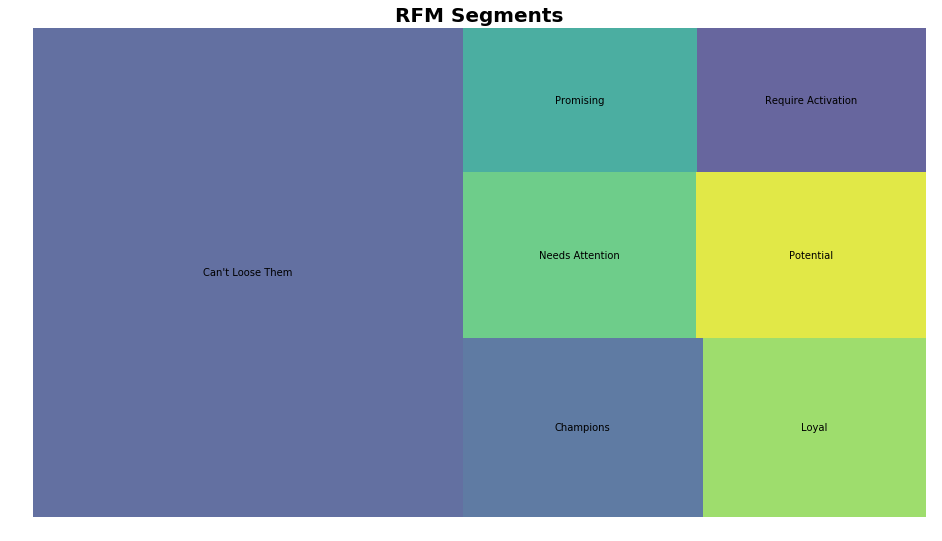

In [34]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=dataset_rfm_count['RFM_Level'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.8 )
plt.title("RFM Segments",fontsize=20,fontweight="bold")
plt.axis('off')
plt.show()

- <b>  Scaling the RFM table </b>

In [35]:
clustering_dataset = dataset_rfm[['Recency','Frequency','Monetary']].copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(clustering_dataset)
scaled = pd.DataFrame(scaled)
scaled.head()

,0,1,2
0,0.871314,0.000000,0.275453
1,0.005362,0.028708,0.015382
2,0.201072,0.014354,0.006414
3,0.048257,0.000000,0.006272
4,0.831099,0.000000,0.001193


- <b> Finding the optimum number of clusters for KMeans clustering model </b>

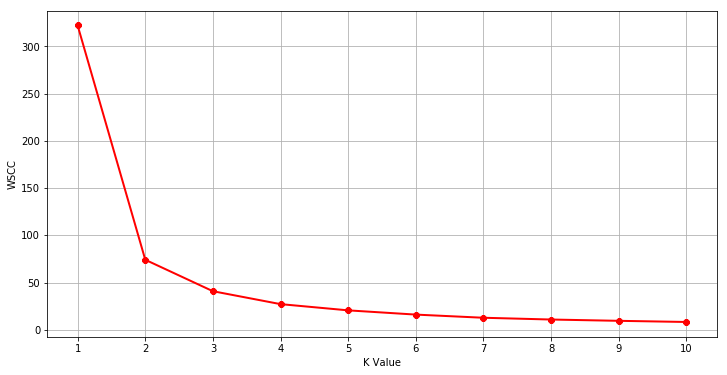

In [41]:
WSCC = []
for cluster in range(1,11):
    kmeans = KMeans(init = 'k-means++', n_clusters = cluster)
    kmeans.fit(scaled)
    WSCC.append(kmeans.inertia_)

plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11), WSCC, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WSCC")
plt.show()

- Optimum number of clusters is 3.

 - <b>KMeans Clustering Model </b>

In [73]:
kmeans_final = KMeans(n_clusters = 3, init = 'k-means++', random_state = 12, n_init = 10, max_iter = 300)
kmeans_final.fit(scaled)
pred = kmeans_final.predict(scaled)
print(pred)

[1 0 0 ... 0 0 0]


In [74]:
final_dataset = pd.DataFrame(clustering_dataset)
final_dataset['cluster'] = pred
final_dataset.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346.0,3480,1.0,77183.60,1
12347.0,3157,7.0,4310.00,0
12348.0,3230,4.0,1797.24,0
12349.0,3173,1.0,1757.55,0
12350.0,3465,1.0,334.40,1


In [75]:
score = silhouette_score (scaled, kmeans_final.labels_)
print("Score of KMeans Clustering Model : ", score)

Score of KMeans Clustering Model :  0.6443025264005886


- <b> Best Cluster </b>

In [76]:
final_dataset.groupby('cluster').mean()

,Recency,Frequency,Monetary
cluster,,,
0,3186.512935,5.477406,2711.660932
1,3448.942492,1.354633,605.716166
2,3307.315725,2.222359,794.748810


 - <b>Cluster 0</b> is the best cluster since it has high monetory value, frequency and less recency compared to other clusters.

- <b> Conclusion </b>
  - Performed RFM analysis on the customer dataset.
  - Segregated customers into different clusters using k means clustering technique.